<a href="https://colab.research.google.com/github/Ed-Marcavage/PyTorch/blob/Exercises/classification_exercise_refresher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import make_moons

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_moons(n_samples, random_state=42)

In [2]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.0087,  0.3682],
         [ 0.9214, -0.4969],
         [ 0.9402, -0.4982],
         [ 0.4659, -0.3454],
         [-0.8504,  0.5261]]),
 tensor([1., 1., 1., 1., 0.]))

In [3]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [4]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0

class warmUpModelv0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_one = nn.Linear(in_features=2, out_features=10) # takes in 2 features (X), UPSCALES to 5 features
    self.layer_two = nn.Linear(in_features=10, out_features=10) # takes in 2 features (X), UPSCALES to 5 features
    self.layer_three = nn.Linear(in_features=10, out_features=10) # takes in 2 features (X), UPSCALES to 5 features
    self.layer_four = nn.Linear(in_features=10, out_features=1) # takes in 5 features, produces 1 feature (y)

  def forward(self,x):
    return self.layer_four(self.layer_three(self.layer_two(self.layer_one(x))))

# 4. Create an instance of the model and send it to target device
model_0 = warmUpModelv0().to(device)
model_0

warmUpModelv0(
  (layer_one): Linear(in_features=2, out_features=10, bias=True)
  (layer_two): Linear(in_features=10, out_features=10, bias=True)
  (layer_three): Linear(in_features=10, out_features=10, bias=True)
  (layer_four): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

In [7]:
device, next(model_0.parameters()).device

('cpu', device(type='cpu'))

In [8]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.1521],
        [0.0821],
        [0.1298],
        [0.0814],
        [0.0748],
        [0.0640],
        [0.0960],
        [0.1060],
        [0.1336],
        [0.0828]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [9]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

###Train model
- Forward Pass
- Calc the loss
- Zero gradients
- Perform backpropagation on the loss
- Ser the optimizer (gradient descent)


###Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)


In [10]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.1521],
        [0.0821],
        [0.1298],
        [0.0814],
        [0.0748]])

In [11]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5380],
        [0.5205],
        [0.5324],
        [0.5203],
        [0.5187]])

In [12]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [13]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [14]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# Build training and evaluation loop
for epoch in range(epochs):

    ### Set Training Mode
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)

    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # sigmoid - creates preds probs
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69426, Accuracy: 50.00% | Test loss: 0.68850, Test acc: 50.00%
Epoch: 100 | Loss: 0.24355, Accuracy: 87.88% | Test loss: 0.24840, Test acc: 89.50%
Epoch: 200 | Loss: 0.23735, Accuracy: 88.88% | Test loss: 0.23877, Test acc: 90.00%
Epoch: 300 | Loss: 0.23731, Accuracy: 89.00% | Test loss: 0.23847, Test acc: 90.00%
Epoch: 400 | Loss: 0.23731, Accuracy: 89.00% | Test loss: 0.23846, Test acc: 90.00%
Epoch: 500 | Loss: 0.23731, Accuracy: 89.00% | Test loss: 0.23845, Test acc: 90.00%
Epoch: 600 | Loss: 0.23731, Accuracy: 89.00% | Test loss: 0.23845, Test acc: 90.00%
Epoch: 700 | Loss: 0.23731, Accuracy: 89.00% | Test loss: 0.23845, Test acc: 90.00%
Epoch: 800 | Loss: 0.23731, Accuracy: 89.00% | Test loss: 0.23845, Test acc: 90.00%
Epoch: 900 | Loss: 0.23731, Accuracy: 89.00% | Test loss: 0.23845, Test acc: 90.00%


In [15]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

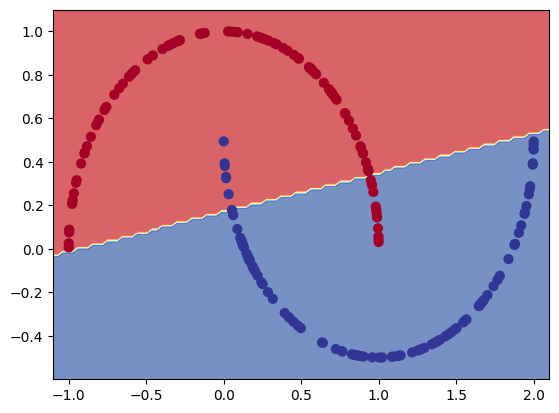

In [16]:
plot_decision_boundary(model_0,X_test, y_test)

In [17]:
#https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh
import torch
import matplotlib.pyplot as plt

def custom_tanh(z):
    return (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))

In [18]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)

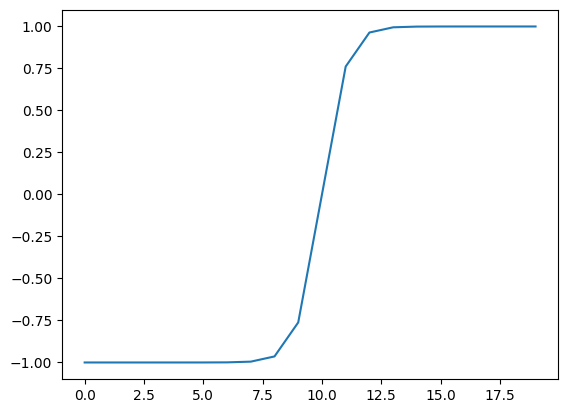

In [19]:
plt.plot(custom_tanh(A))

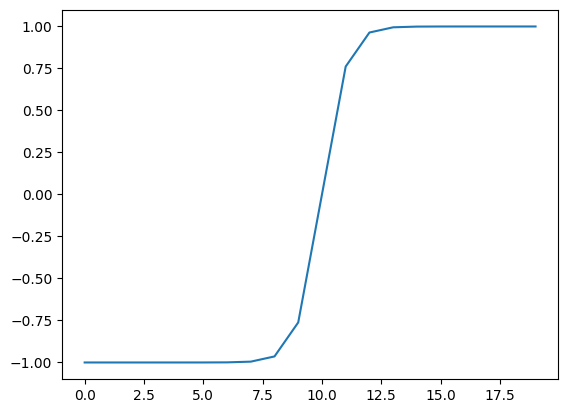

In [20]:
plt.plot(torch.tanh(A))

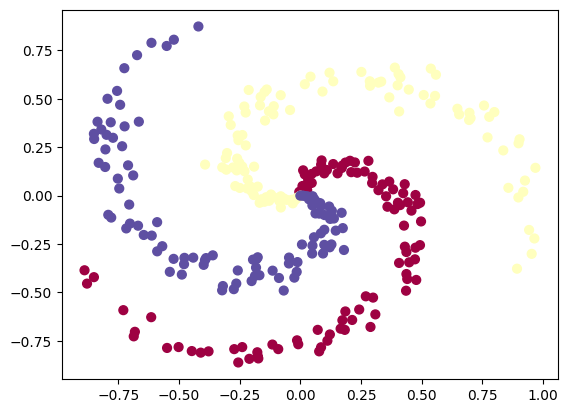

In [21]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [ ]:
from torch import nn

# class BlobModel(nn.Module):
#   def __init__(self, input_features, output_features, hidden_units=8):

#     super().__init__()
#     self.linear_layer_stack = nn.Sequential(
#     nn.Linear(in_features=input_features, out_features=hidden_units),
#     nn.ReLU(),
#     nn.Linear(in_features=hidden_units, out_features=hidden_units),
#     nn.ReLU(),
#     nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
# )

#   def forward(self, x):
#         return self.linear_layer_stack(x)

class warmUpModelv2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_one = nn.Linear(in_features=2, out_features=10) # takes in 2 features (X), UPSCALES to 5 features
    self.layer_two = nn.Linear(in_features=10, out_features=10) # takes in 2 features (X), UPSCALES to 5 features
    self.layer_three = nn.Linear(in_features=10, out_features=10) # takes in 2 features (X), UPSCALES to 5 features
    self.layer_four = nn.Linear(in_features=10, out_features=1) # takes in 5 features, produces 1 feature (y)

  def forward(self,x):
    return self.layer_four(nn.ReLU(self.layer_three(nn.ReLU(self.layer_two(nn.ReLU(self.layer_one(x)))))))

# 4. Create an instance of the model and send it to target device
model_2 = warmUpModelv2().to(device)
model_2.state_dict()

In [26]:
loss_fn_v2 = nn.BCEWithLogitsLoss()

optimizer_v2 = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [28]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)  # Assuming your data is of float type
y_train = torch.tensor(y_train, dtype=torch.int64)  # Assuming your labels are of integer type
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# Build training and evaluation loop
for epoch in range(epochs):

    ### Set Training Mode
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)

    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # sigmoid - creates preds probs
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

RuntimeError: ignored